# 2D dynamical system: Competitive Lotka-Volterra equations

## Model introduction

We consider the model where two species $x,y$ do not form predator-prey relation, but compete for common resources in a shared environment. The existence of one species will reduce the effective birth rate of the other due to competition. In the ideal case where one species is absent, the other species will obey logistic model:
$$\frac{dx}{dt} = (a-ky)x-bx^{2}$$
$$\frac{dy}{dt}= (c-\sigma x)y-py^{2}$$
where $a,k,b,c,\sigma,p$ are positive constants.

With choice of $a=0.9,b=1,k=1,c=1,\sigma=0.5,p=2$, there are four equilibriums: $(\frac{8}{15}, \frac{11}{30})$, which is a nodal sink. $(0,0)$, which is a nodal source. $(0.9, 0)$, which is a saddle. $(0, 0.5)$, which is a saddle. We are interested in estimating the basin of attraction of the nodal sink equilibrium, which is $(\frac{8}{15}, \frac{11}{30})$.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
def lotka_volterra(t, X):
    x, y = X
    xp = 0.9*x - x*y - x*x
    yp = y - 0.5*x*y - 2*y*y
    return xp, yp

/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_57347/3036040274.py:7: RuntimeWarning: invalid value encountered in divide
  U = U / N
/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_57347/3036040274.py:8: RuntimeWarning: invalid value encountered in divide
  V = V / N


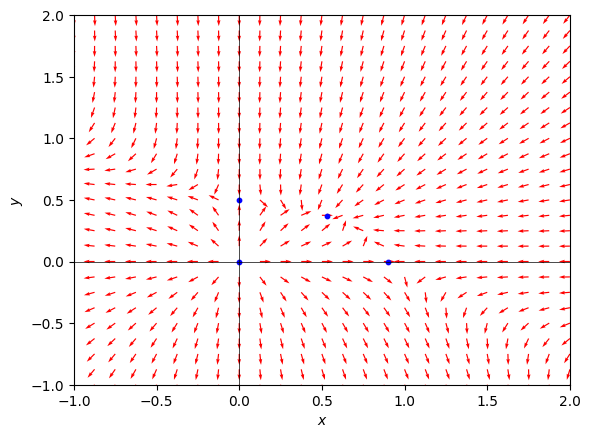

In [24]:
# Define the system of equations
Y, X = np.mgrid[-1:2:25j, -1:2:25j] 
U, V = lotka_volterra(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.9, 0, 8/15], [0, 0, 0.5, 11/30], color='blue', s=10) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-1, 2])  # x-axis limits include negative values
plt.ylim([-1, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

By plot(and we could further verify by checking the eigenvectors of Jacobian matrix near each equilibrium), we see that the actual boundary for the basin of attraction of $(\frac{8}{15}, \frac{11}{30})$ is the union of non-negative x-axis and y-axis. If an initial condition in first quadrant is close to axis, we could see that it is first attracted to one of the saddle, then move away from the saddle to be attracted by the nodal sink.

In this simple case, access to the ground truth of boundary makes it easier to collect datapoints: We generate the initial dataset by uniform sampling. If it is in the first quadrant, we give label +1, else label -1. We do not need to run numerical solver to check.

## Generate datasets

In [26]:
# Generate 100,000 random data points in the space (-1, 2) * (-1, 2)
x = np.random.uniform(-1, 2, 100000)
y = np.random.uniform(-1, 2, 100000)

# Assign labels
labels = np.where((x > 0) & (y > 0), 1, -1)

# Combine x, y, and labels into a single dataframe with column labels
data = pd.DataFrame({'x0': x, 'y0': y, 'label': labels})

# Save data to a CSV file
data.to_csv("dataset_lv2d.csv", index=False)

We apply bisection routine to create another dataset of near-boundary points. We set the margin $\delta=0.01$.

In [28]:
def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

def bisection(a, b, delta=0.01): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if (c[0] > 0) & (c[1] > 0):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

In [29]:
## Generate a dataset of near-boundary points
data = pd.read_csv("dataset_lv2d.csv")
data_1 = data[data['label'] == 1].sample(1000)
data_n1 = data[data['label'] == -1].sample(1000)

dataset_near = []
for i in range(len(data_1)):
    for j in range(len(data_n1)):
        a = (data_1.iloc[i]['x0'], data_1.iloc[i]['y0'])
        b = (data_n1.iloc[j]['x0'], data_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])



In [30]:
dataset_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'label'])
dataset_near.to_csv("dataset_lv2d_near.csv", index=False)